# Air Quality (UCI) — EDA + Data Preprocessing

## Load data

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("../data/AirQualityUCI.csv")

# Robust read: UCI often uses ';' as separator and ',' as decimal; trailing Unnamed column may exist
df_raw = pd.read_csv(
    data_path,
    sep=';',
    decimal=',',
    header=0,
    engine='python'
)
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains(r'^Unnamed')].copy()

print("Columns:", list(df_raw.columns))
print("Shape (raw):", df_raw.shape)
display(df_raw.head(3))

df = df_raw.replace(-200, np.nan).copy()


Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Shape (raw): (9471, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


## Missing values overview

NMHC(GT)         90.35
CO(GT)           18.97
NO2(GT)          18.54
NOx(GT)          18.51
PT08.S2(NMHC)     5.07
C6H6(GT)          5.07
PT08.S1(CO)       5.07
PT08.S5(O3)       5.07
T                 5.07
PT08.S3(NOx)      5.07
PT08.S4(NO2)      5.07
RH                5.07
AH                5.07
Date              1.20
Time              1.20
dtype: float64


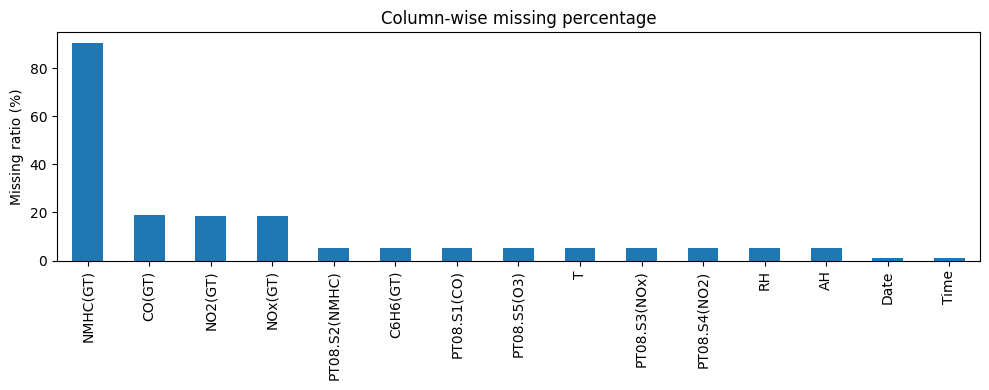

In [12]:

miss = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print(miss)

plt.figure(figsize=(10, 4))
miss.plot(kind='bar')
plt.ylabel("Missing ratio (%)")
plt.title("Column-wise missing percentage")
plt.tight_layout()
plt.show()


##  Time-ordered missingness heatmap (NaN=White, Valid=Black)

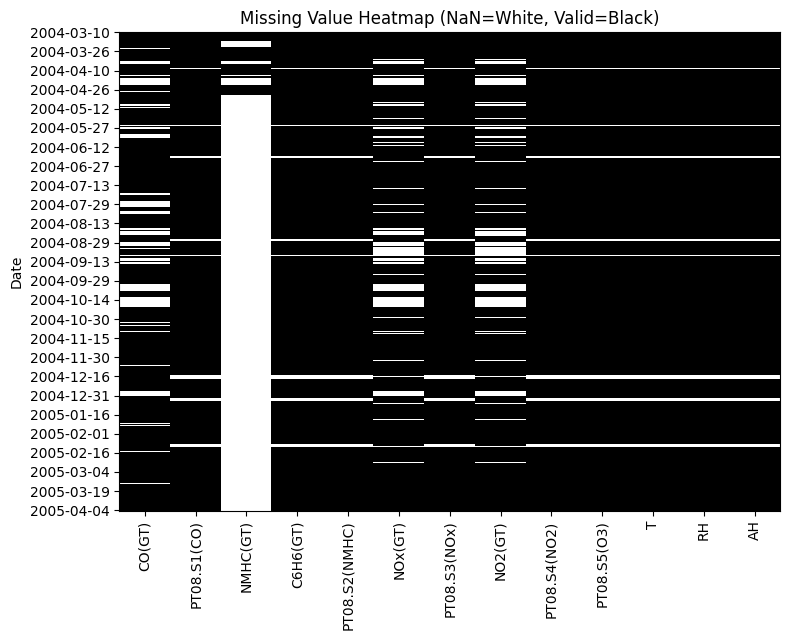

In [13]:

# Build a temporary timestamp for visualization only
if 'Date' in df.columns and 'Time' in df.columns:
    ts = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str),
        format='%d/%m/%Y %H.%M.%S',
        errors='coerce'
    )
    df_time = df.copy()
    df_time.index = ts
    df_time = df_time.loc[~df_time.index.isna()].sort_index()

    # Align to hourly frequency so gaps appear as NaN
    df_hourly = df_time.asfreq('h')

    cols = [c for c in [
        'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
        'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
        'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
        'T', 'RH', 'AH'
    ] if c in df_hourly.columns]

    if cols:
        import numpy as np
        missing_mat = df_hourly[cols].isna().astype(int).values  # 1=NaN(white), 0=valid(black)

        fig, ax = plt.subplots(figsize=(8, 6.5))
        ax.imshow(missing_mat, aspect='auto', cmap='gray', interpolation='nearest')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols, rotation=90)

        n = missing_mat.shape[0]
        step = max(n // 25, 1)
        yticks = np.arange(0, n, step)
        ylabels = [df_hourly.index[i].strftime('%Y-%m-%d') for i in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)

        ax.set_title('Missing Value Heatmap (NaN=White, Valid=Black)')
        ax.set_ylabel('Date')
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric target columns present for heatmap.")
else:
    print("Date/Time columns not found; skipping time-ordered heatmap.")


## Correlations among pollutants & with meteorological variables

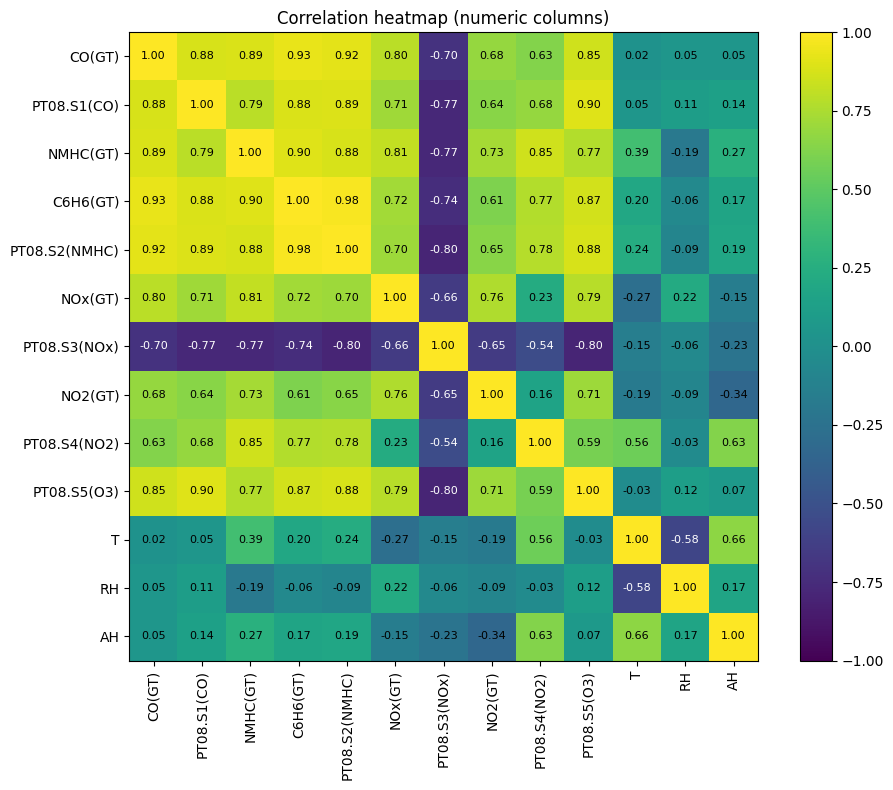

In [14]:

num_df = df.select_dtypes(include=[np.number])

corr = num_df.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation='nearest', cmap='viridis', vmin=-1, vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
for i in range(len(corr.columns)):
    for j in range(len(corr.index)):
        value = corr.iloc[j, i]
        color = "black" if value > -0.5 else "white"
        plt.text(i, j, f"{value:.2f}", ha="center", va="center", color=color, fontsize=8)

plt.colorbar()
plt.title("Correlation heatmap (numeric columns)")
plt.tight_layout()
plt.show()



## data preprocessing

In [15]:

# Configuration
HIGH_MISS_THRESHOLD = 0.90  # if a column has >90% missing, drop it (set to None to disable)
SAVE_CSV = Path("../data/airquality_clean.csv")


In [16]:
ts = pd.to_datetime(
    df['Date'].astype(str) + ' ' + df['Time'].astype(str),
    format='%d/%m/%Y %H.%M.%S',
    errors='coerce'
)
df.insert(0, 'datetime', ts)
df = df.dropna(subset=['datetime']).drop(columns=['Date', 'Time']).copy()
df = df.set_index('datetime').sort_index()

print("Shape after merging Date & Time:", df.shape)

df['Hour'] = df.index.hour
df['Weekday'] = df.index.weekday
df['Month'] = df.index.month

print("Derived time features added.")
display(df.head())

Shape after merging Date & Time: (9357, 13)
Derived time features added.


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Weekday,Month
datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2,3
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2,3
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2,3
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2,3
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2,3


### Time Pattern Analysis with Normalization

Columns used for time pattern plots: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


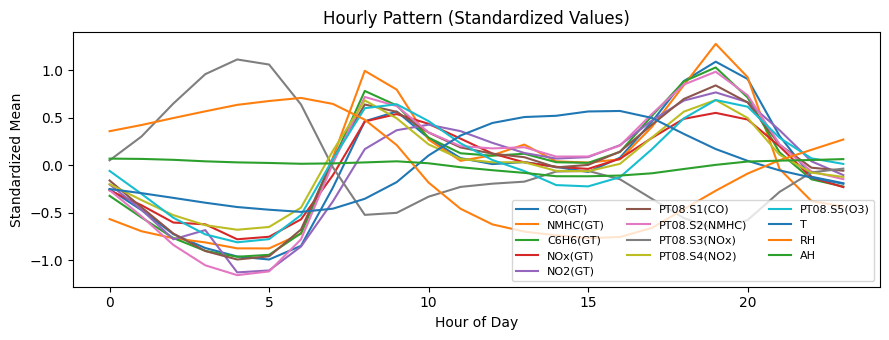

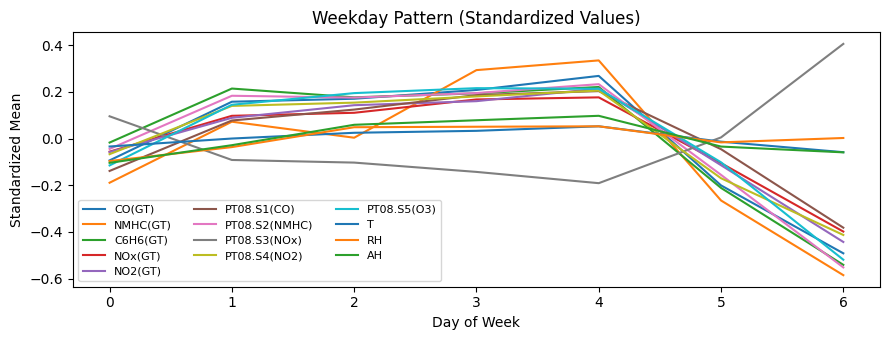

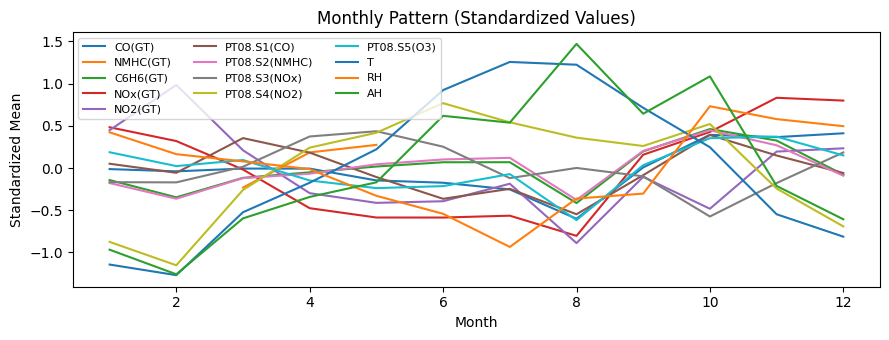

In [17]:
import matplotlib.pyplot as plt

cols = [c for c in [
    'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)',
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
] if c in df.columns]

print("Columns used for time pattern plots:", cols)

# ====== normalization=====
df_norm = df.copy()
df_norm[cols] = (df_norm[cols] - df_norm[cols].mean()) / df_norm[cols].std()

plt.style.use('default')

# ---- Hourly pattern ----
hourly_mean = df_norm.groupby('Hour')[cols].mean()
plt.figure(figsize=(9, 3.5))
for c in cols:
    plt.plot(hourly_mean.index, hourly_mean[c], label=c)
plt.title("Hourly Pattern (Standardized Values)")
plt.xlabel("Hour of Day")
plt.ylabel("Standardized Mean")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# ---- Weekday pattern ----
weekday_mean = df_norm.groupby('Weekday')[cols].mean()
plt.figure(figsize=(9, 3.5))
for c in cols:
    plt.plot(weekday_mean.index, weekday_mean[c], label=c)
plt.title("Weekday Pattern (Standardized Values)")
plt.xlabel("Day of Week")
plt.ylabel("Standardized Mean")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# ---- Monthly pattern ----
monthly_mean = df_norm.groupby('Month')[cols].mean()
plt.figure(figsize=(9, 3.5))
for c in cols:
    plt.plot(monthly_mean.index, monthly_mean[c], label=c)
plt.title("Monthly Pattern (Standardized Values)")
plt.xlabel("Month")
plt.ylabel("Standardized Mean")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


### Relationships between Meteorological Variables and Pollutant Concentrations (GT and PT08)

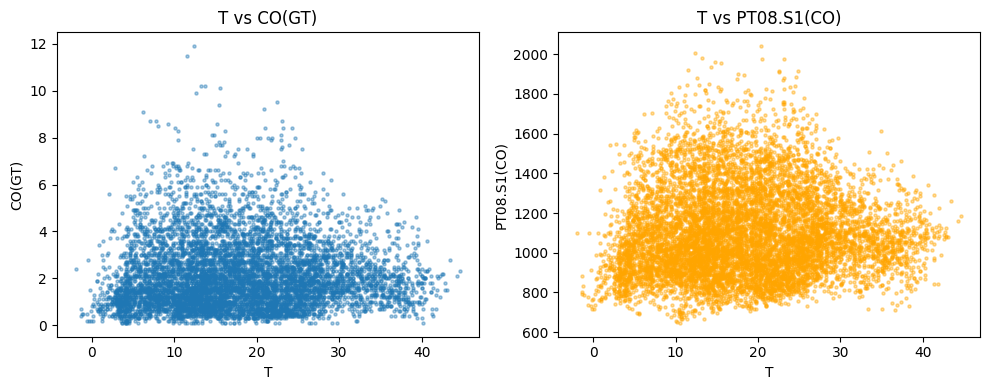

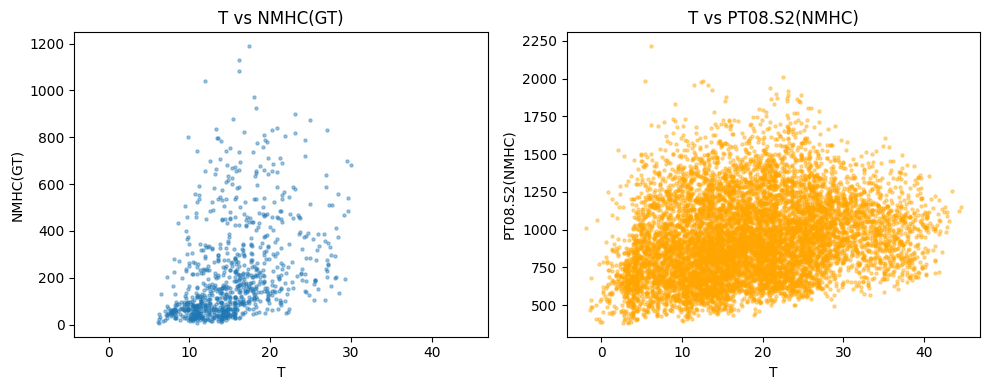

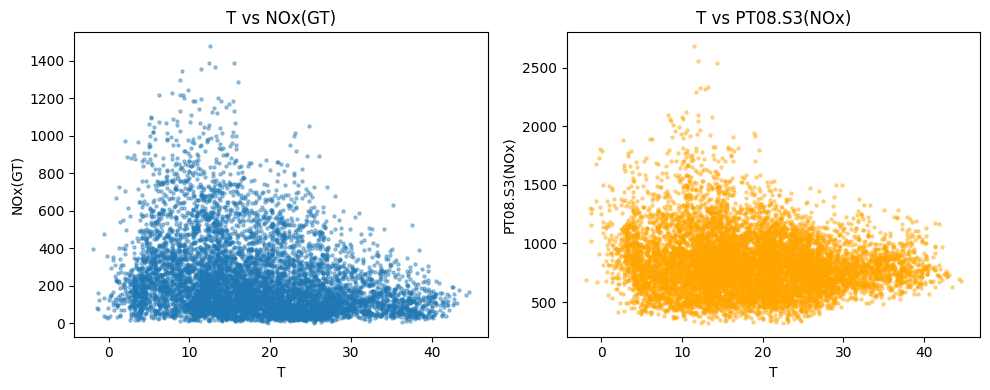

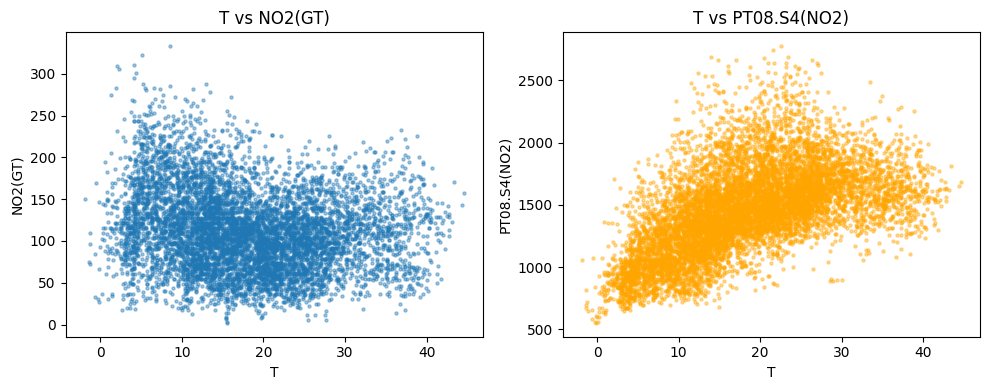

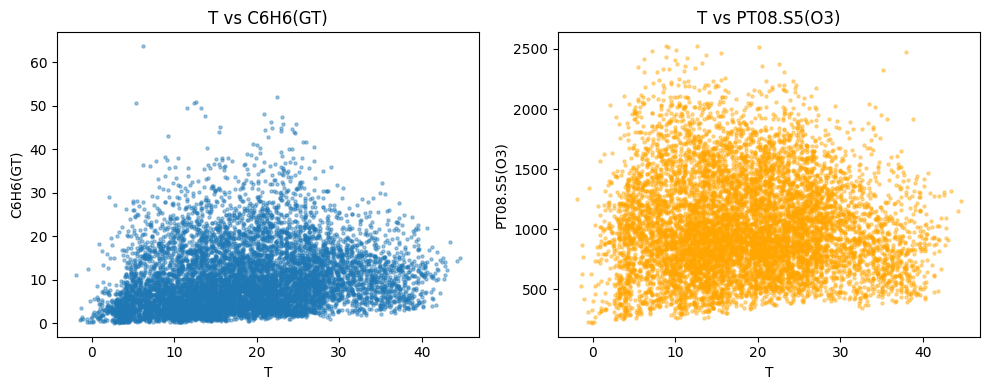

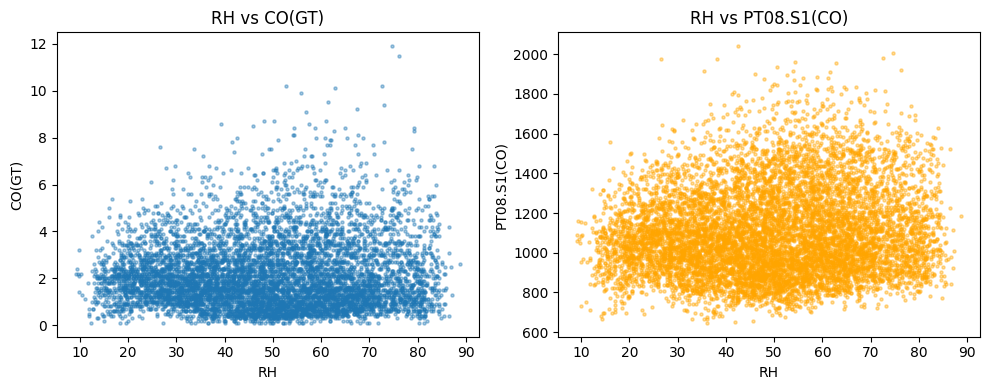

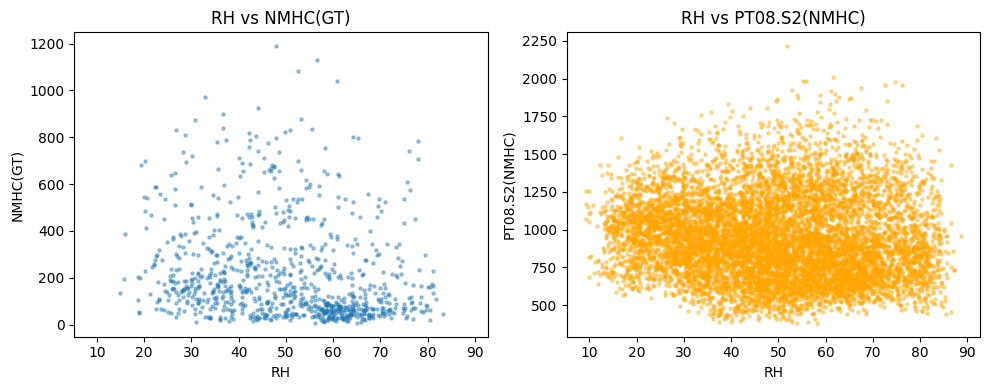

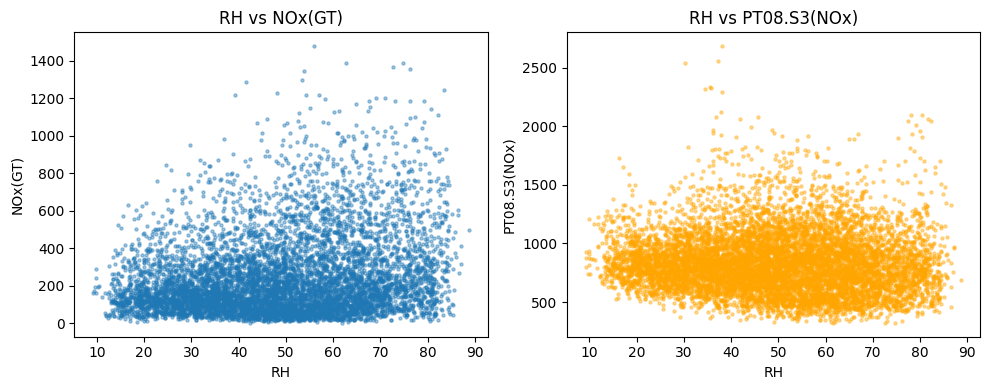

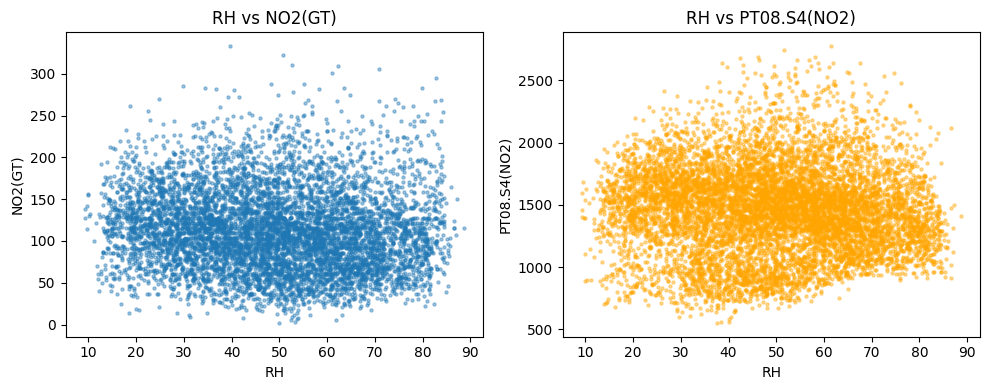

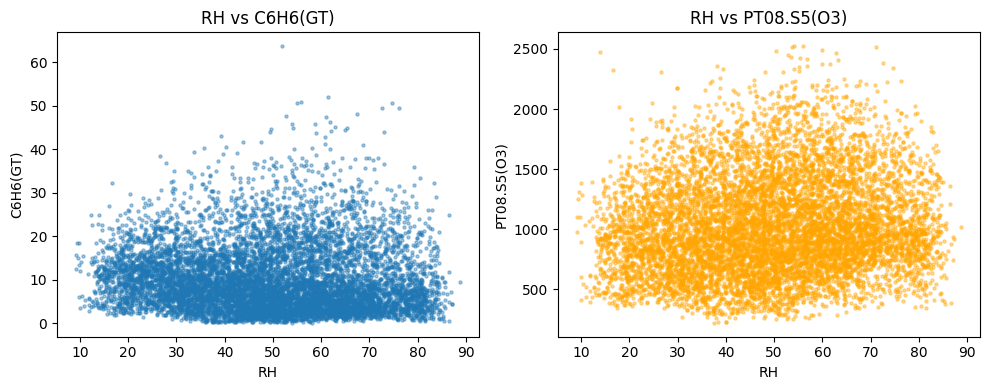

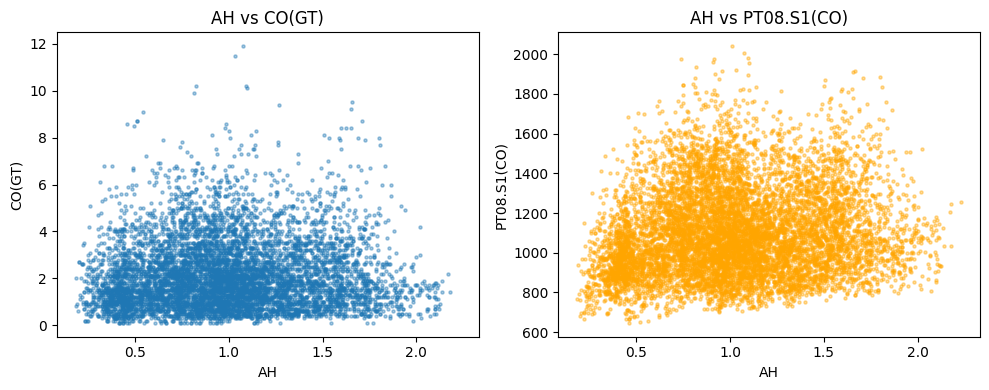

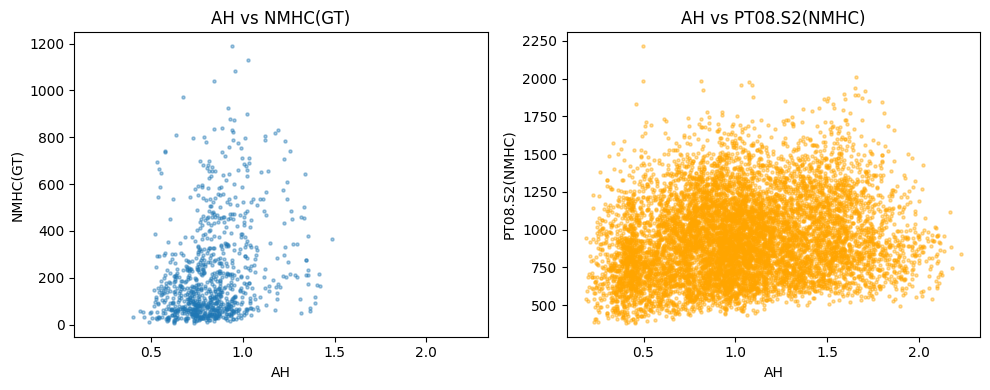

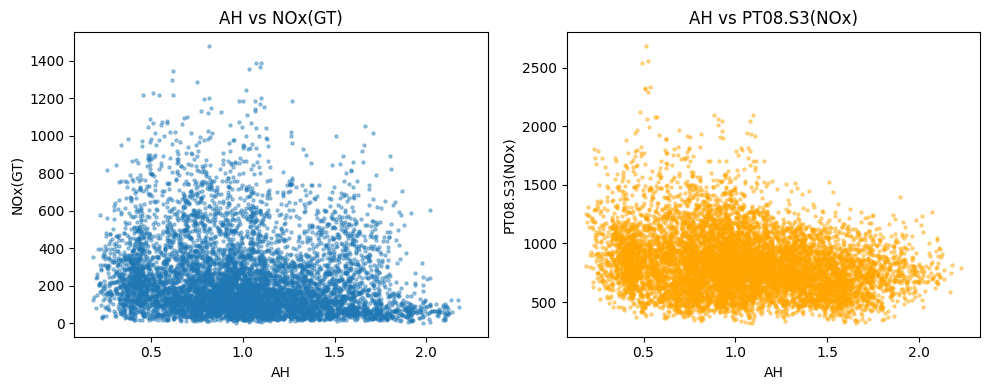

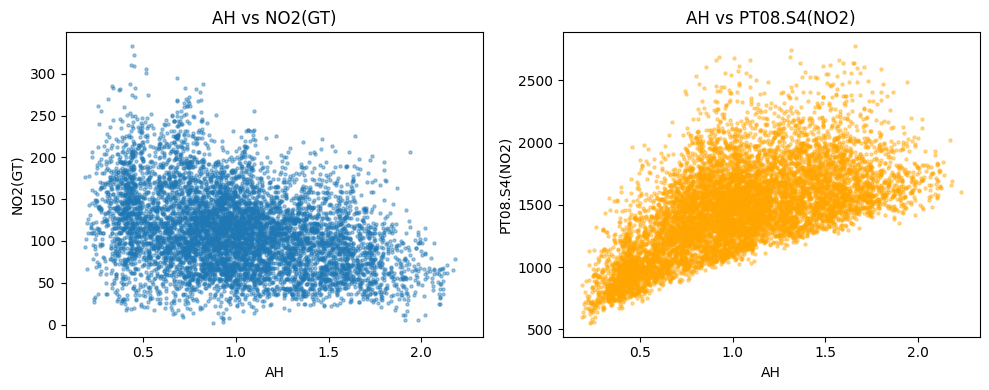

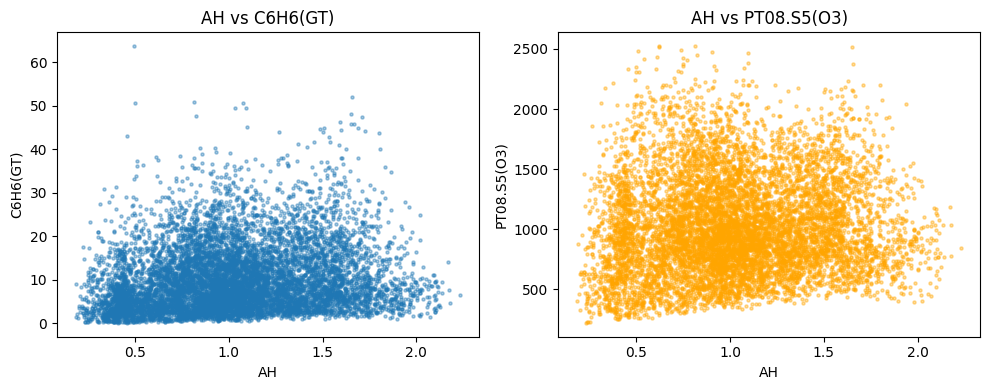

In [18]:
import matplotlib.pyplot as plt

# 对应关系：GT 列 ↔ 传感器列
pairs = [
    ('T',  'CO(GT)',  'PT08.S1(CO)'),
    ('T',  'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('T',  'NOx(GT)',  'PT08.S3(NOx)'),
    ('T',  'NO2(GT)',  'PT08.S4(NO2)'),
    ('T',  'C6H6(GT)',  'PT08.S5(O3)'),
    ('RH', 'CO(GT)',  'PT08.S1(CO)'),
    ('RH', 'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('RH', 'NOx(GT)',  'PT08.S3(NOx)'),
    ('RH', 'NO2(GT)',  'PT08.S4(NO2)'),
    ('RH',  'C6H6(GT)',  'PT08.S5(O3)'),
    ('AH', 'CO(GT)',  'PT08.S1(CO)'),
    ('AH', 'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('AH', 'NOx(GT)',  'PT08.S3(NOx)'),
    ('AH', 'NO2(GT)',  'PT08.S4(NO2)'),
    ('AH',  'C6H6(GT)',  'PT08.S5(O3)'),
]

for x_col, gt_col, sensor_col in pairs:
    if x_col in df.columns and gt_col in df.columns and sensor_col in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
        
        # 左：气象变量 vs GT 浓度
        axes[0].scatter(df[x_col], df[gt_col], s=5, alpha=0.4)
        axes[0].set_xlabel(x_col)
        axes[0].set_ylabel(gt_col)
        axes[0].set_title(f"{x_col} vs {gt_col}")

        # 右：气象变量 vs PT08 传感器输出
        axes[1].scatter(df[x_col], df[sensor_col], s=5, alpha=0.4, color='orange')
        axes[1].set_xlabel(x_col)
        axes[1].set_ylabel(sensor_col)
        axes[1].set_title(f"{x_col} vs {sensor_col}")

        plt.tight_layout()
        plt.show()


## Interpolation

In [19]:
gap_limit = 3
interp_cols = [c for c in [
    'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)',
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
] if c in df.columns]
print("插值前各列缺失值统计：")
display(df[interp_cols].isna().sum().to_frame("n_missing").assign(
    missing_pct=lambda s: s["n_missing"] / len(df) * 100
))

round_specs = {
    "CO(GT)": 1,
    "NMHC(GT)": 1,
    "C6H6(GT)": 1,
    "NOx(GT)": 1,
    "NO2(GT)": 1,

    "PT08.S1(CO)": 0,
    "PT08.S2(NMHC)": 0,
    "PT08.S3(NOx)": 0,
    "PT08.S4(NO2)": 0,
    "PT08.S5(O3)": 0,

    "T": 1,
    "RH": 1,
    "AH": 4,
}

for col in interp_cols:
    df[col] = df[col].interpolate(
        method="time",
        limit=gap_limit,
        limit_direction="both",
    ).round(round_specs.get(col))
print("插值后各列缺失值统计：")
display(df[interp_cols].isna().sum().to_frame("n_missing").assign(
    missing_pct=lambda s: s["n_missing"] / len(df) * 100
))

插值前各列缺失值统计：


,n_missing,missing_pct
CO(GT),1683,17.986534
NMHC(GT),8443,90.231912
C6H6(GT),366,3.911510
NOx(GT),1639,17.516298
NO2(GT),1642,17.548360
PT08.S1(CO),366,3.911510
PT08.S2(NMHC),366,3.911510
PT08.S3(NOx),366,3.911510
PT08.S4(NO2),366,3.911510
PT08.S5(O3),366,3.911510


插值后各列缺失值统计：


,n_missing,missing_pct
CO(GT),1333,14.246019
NMHC(GT),8415,89.932671
C6H6(GT),291,3.109971
NOx(GT),1188,12.696377
NO2(GT),1190,12.717751
PT08.S1(CO),291,3.109971
PT08.S2(NMHC),291,3.109971
PT08.S3(NOx),291,3.109971
PT08.S4(NO2),291,3.109971
PT08.S5(O3),291,3.109971


## save df to csv

In [20]:
from pathlib import Path

out_dir = Path("../data")
out_dir.mkdir(parents=True, exist_ok=True)

df_all = df.copy()
p1_csv = out_dir / "airquality_clean.csv"
df_all.to_csv(p1_csv, index=True)